In [30]:
from pandas import read_csv, DataFrame, Series
from statsmodels.tsa.arima.model import ARIMA
from dslabs_functions import series_train_test_split, HEIGHT

filename: str = "../set_2_diff_2.csv"
file_tag: str = "Set 1"
target: str = "GDP"
timecol: str = "Date"
measure: str = "R2"

data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
series: Series = data[target]
train, test = series_train_test_split(data, trn_pct=0.90)

predictor = ARIMA(train, order=(3, 1, 2))
model = predictor.fit()
print(model.summary())

ValueError: 'Date' is not in list

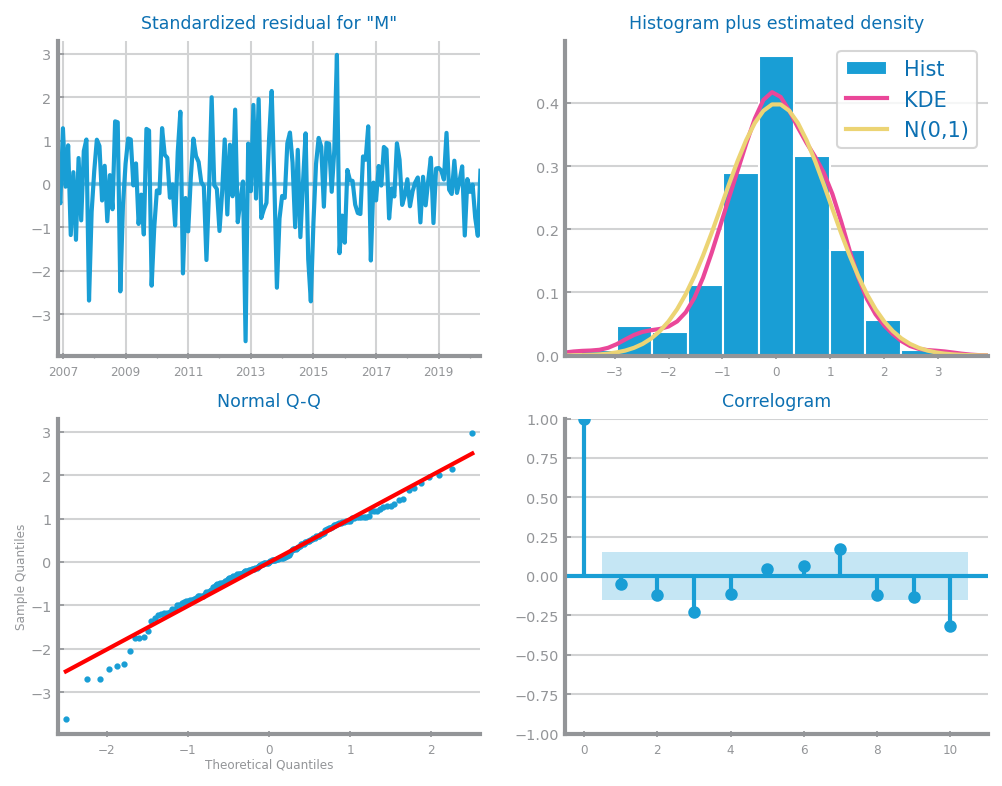

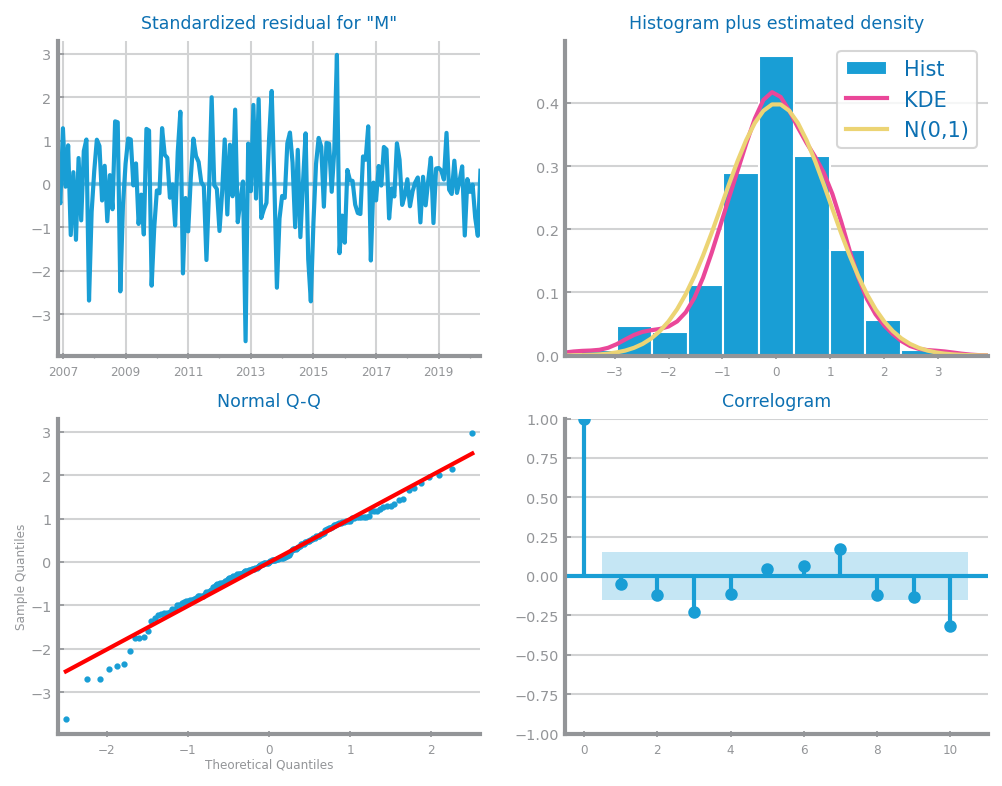

In [24]:
model.plot_diagnostics(figsize=(2 * HEIGHT, 1.5 * HEIGHT))

In [25]:
from matplotlib.pyplot import figure, savefig, subplots
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart
from tqdm.notebook import tqdm


def arima_study(train: Series, test: Series, measure: str = "R2"):
    d_values = (0, 1, 2)
    p_params = (1, 2, 3, 5, 7, 10)
    q_params = (1, 3, 5, 7)

    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "ARIMA", "metric": measure, "params": ()}
    best_performance: float = -100000

    fig, axs = subplots(1, len(d_values), figsize=(len(d_values) * HEIGHT, HEIGHT))
    for i in tqdm(range(len(d_values)), 'd_values', position=1):
        d: int = d_values[i]
        values = {}
        for q in tqdm(q_params, 'q_params', position=2):
            yvalues = []
            for p in tqdm(p_params, 'p_params', position=3):
                arima = ARIMA(train, order=(p, d, q))
                model = arima.fit()
                prd_tst = model.forecast(steps=len(test), signal_only=False)
                eval: float = FORECAST_MEASURES[measure](test, prd_tst)
                # print(f"ARIMA ({p}, {d}, {q})", eval)
                if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                    best_performance: float = eval
                    best_params["params"] = (p, d, q)
                    best_model = model
                yvalues.append(eval)
            values[q] = yvalues
        plot_multiline_chart(
            p_params, values, ax=axs[i], title=f"ARIMA d={d} ({measure})", xlabel="p", ylabel=measure, percentage=flag
        )
    print(
        f"ARIMA best results achieved with (p,d,q)=({best_params['params'][0]:.0f}, {best_params['params'][1]:.0f}, {best_params['params'][2]:.0f}) ==> measure={best_performance:.2f}"
    )

    return best_model, best_params

d_values:   0%|          | 0/3 [00:00<?, ?it/s]

q_params:   0%|          | 0/4 [00:00<?, ?it/s]

p_params:   0%|          | 0/6 [00:00<?, ?it/s]

p_params:   0%|          | 0/6 [00:00<?, ?it/s]

p_params:   0%|          | 0/6 [00:00<?, ?it/s]

p_params:   0%|          | 0/6 [00:00<?, ?it/s]

q_params:   0%|          | 0/4 [00:00<?, ?it/s]

p_params:   0%|          | 0/6 [00:00<?, ?it/s]

p_params:   0%|          | 0/6 [00:00<?, ?it/s]

p_params:   0%|          | 0/6 [00:00<?, ?it/s]

p_params:   0%|          | 0/6 [00:00<?, ?it/s]

q_params:   0%|          | 0/4 [00:00<?, ?it/s]

p_params:   0%|          | 0/6 [00:00<?, ?it/s]

p_params:   0%|          | 0/6 [00:00<?, ?it/s]

p_params:   0%|          | 0/6 [00:00<?, ?it/s]

p_params:   0%|          | 0/6 [00:00<?, ?it/s]

ARIMA best results achieved with (p,d,q)=(10, 1, 3) ==> measure=0.44


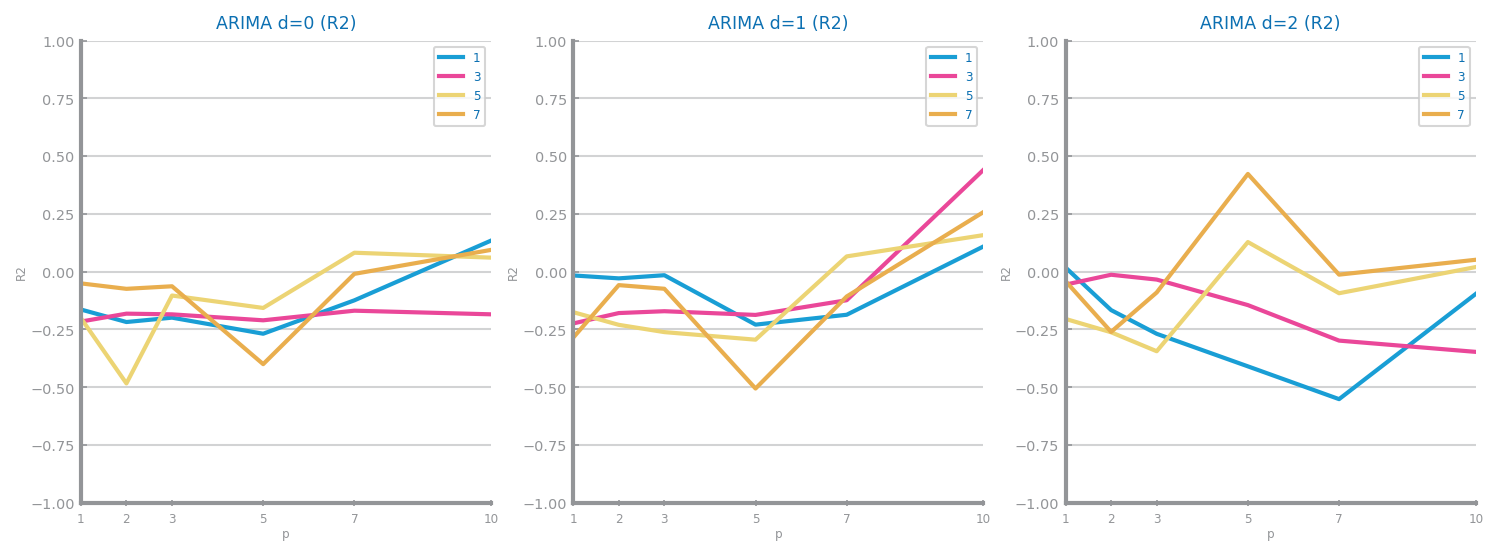

In [26]:
from matplotlib.pyplot import savefig

best_model, best_params = arima_study(train, test, measure=measure)
savefig(f"./images_ARIMA/{file_tag}_arima_{measure}_study.png")

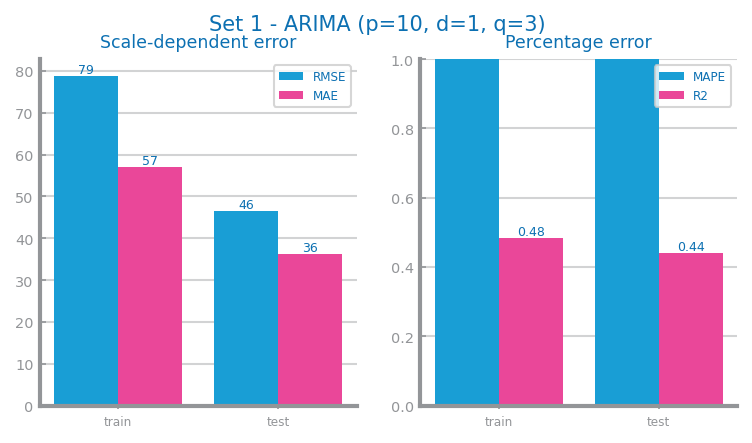

In [27]:
from dslabs_functions import plot_forecasting_eval

params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1)
prd_tst = best_model.forecast(steps=len(test))

plot_forecasting_eval(
    train, test, prd_trn, prd_tst, title=f"{file_tag} - ARIMA (p={params[0]}, d={params[1]}, q={params[2]})"
)
savefig(f"./images_ARIMA/{file_tag}_arima_{measure}_eval.png")

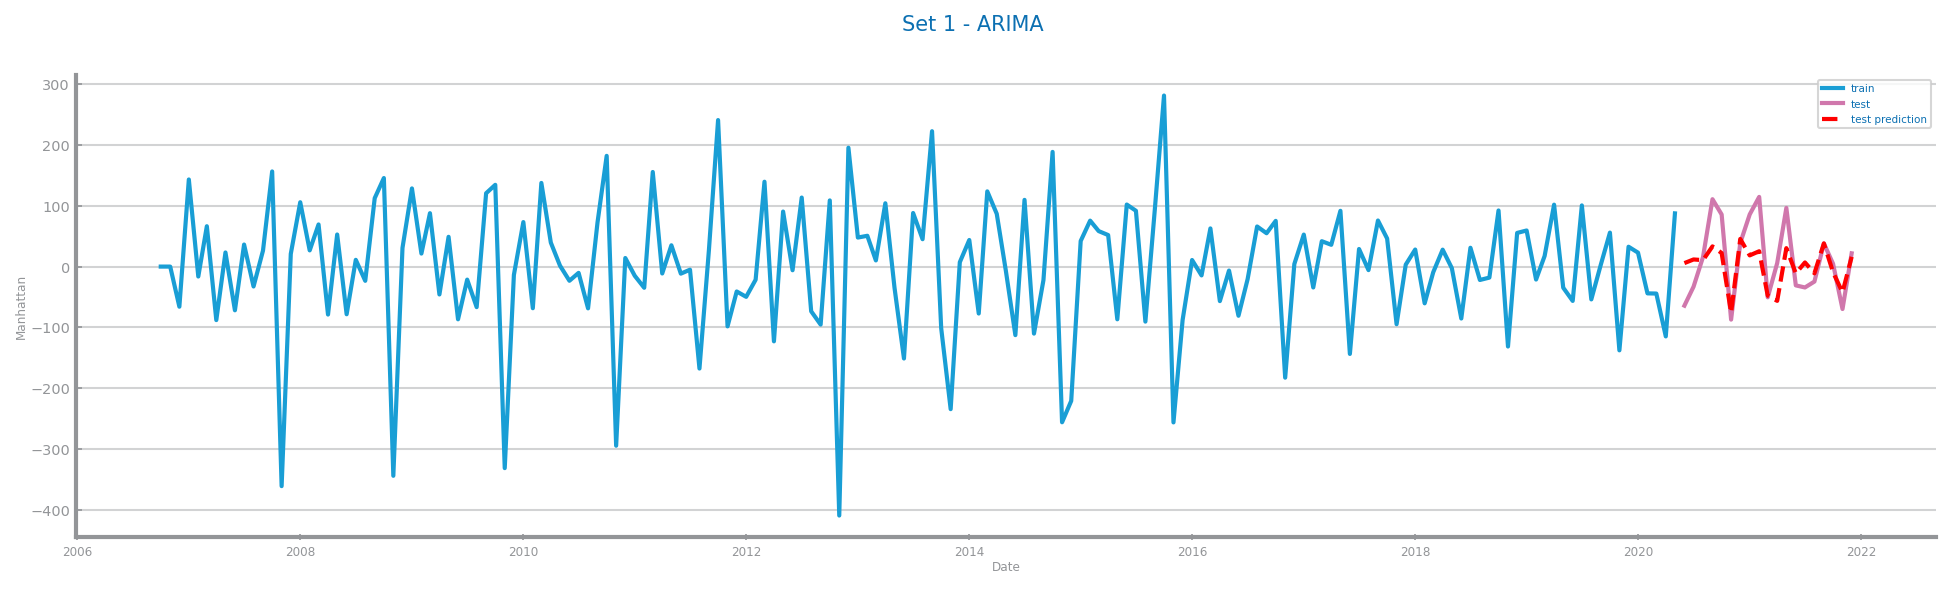

In [28]:
from dslabs_functions import plot_forecasting_series

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - ARIMA ",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"./images_ARIMA/{file_tag}_arima_{measure}_forecast.png")

In [ ]:
from pandas import read_csv, DataFrame, Series
from statsmodels.tsa.arima.model import ARIMA
from dslabs_functions import series_train_test_split, HEIGHT
from matplotlib.pyplot import subplots, savefig
from dslabs_functions import FORECAST_MEASURES, DELTA_IMPROVE, plot_multiline_chart, plot_forecasting_eval, plot_forecasting_series
from sklearn.preprocessing import StandardScaler

filename: str = "/home/mina/Documents/portugal/dataScience/Data_science_project/forecast_ny_arrests.csv"
file_tag: str = "Set 1"
target: str = "Manhattan"
timecol: str = "Date"
measure: str = "R2"

# Load data
data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
series: Series = data[target]

# Select some exogenous variables (example: ['temperature', 'humidity'])
# Replace with the actual column names in your dataset
exog_vars = ['Bronx','Brooklyn','Queens','StatenIsland','Manhattan']
exog_data = data[exog_vars]

train, test = series_train_test_split(data, trn_pct=0.90)
exog_train = exog_data.loc[train.index]
exog_test = exog_data.loc[test.index]

scaler = StandardScaler()
exog_train = scaler.fit_transform(exog_train)
exog_test = scaler.transform(exog_test)

assert len(train) == len(exog_train), "train et exog_train doivent avoir la même taille"
assert len(test) == len(exog_test), "test et exog_test doivent avoir la même taille"


def arima_study_with_exog(train: Series, test: Series, exog_train: DataFrame, exog_test: DataFrame, measure: str = "R2"):
    d_values = (0, 1, 2)
    p_params = (1, 2, 3, 5, 7, 10)
    q_params = (1, 3, 5, 7)

    flag = measure == "R2" or measure == "MAPE"
    best_model = None
    best_params: dict = {"name": "ARIMA", "metric": measure, "params": ()}
    best_performance: float = -100000

    fig, axs = subplots(1, len(d_values), figsize=(len(d_values) * HEIGHT, HEIGHT))
    for i in range(len(d_values)):
        d: int = d_values[i]
        values = {}
        for q in q_params:
            yvalues = []
            for p in p_params:
                arima = ARIMA(train, order=(p, d, q), exog=exog_train)
                model = arima.fit()
                prd_tst = model.forecast(steps=len(test), exog=exog_test)
                eval: float = FORECAST_MEASURES[measure](test, prd_tst)
                if eval > best_performance and abs(eval - best_performance) > DELTA_IMPROVE:
                    best_performance: float = eval
                    best_params["params"] = (p, d, q)
                    best_model = model
                yvalues.append(eval)
            values[q] = yvalues
        plot_multiline_chart(
            p_params, values, ax=axs[i], title=f"ARIMA d={d} ({measure})", xlabel="p", ylabel=measure, percentage=flag
        )
    print(
        f"ARIMA best results achieved with (p,d,q)=({best_params['params'][0]:.0f}, {best_params['params'][1]:.0f}, {best_params['params'][2]:.0f}) ==> measure={best_performance:.2f}"
    )

    return best_model, best_params

# Perform the ARIMA study with exogenous variables
best_model, best_params = arima_study_with_exog(train, test, exog_train, exog_test, measure=measure)
savefig(f"/home/mina/Documents/portugal/dataScience/Data_science_project/MODELS’ EVALUATION/images_ARIMA_mutiplesVariables/{file_tag}_arima_{measure}_study_multivar.png")

# Generate forecasts with the best model
params = best_params["params"]
prd_trn = best_model.predict(start=0, end=len(train) - 1, exog=exog_train)
prd_tst = best_model.forecast(steps=len(test), exog=exog_test)

# Plot evaluation of the forecasts
plot_forecasting_eval(
    train, test, prd_trn, prd_tst, title=f"{file_tag} - ARIMA (p={params[0]}, d={params[1]}, q={params[2]}) with exog"
)
savefig(f"/home/mina/Documents/portugal/dataScience/Data_science_project/MODELS’ EVALUATION/images_ARIMA_mutiplesVariables/{file_tag}_arima_{measure}_eval_multivar.png")

# Plot forecastin                                                                                       g series
plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - ARIMA with exogenous variables",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"/home/mina/Documents/portugal/dataScience/Data_science_project/MODELS’ EVALUATION/images_ARIMA_mutiplesVariables/{file_tag}_arima_{measure}_forecast_multivar.png")
